In [8]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold

In [9]:
data_path = "./TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [10]:
print("Min wind Speed ",data_info.Vmax.min())
print("Max wind Speed ",data_info.Vmax.max())
print("Mean wind Speed ",round(data_info.Vmax.mean(),2))

Min wind Speed  15.0
Max wind Speed  155.0
Mean wind Speed  48.14


In [11]:
np.shape(data_matrix)

(4580, 201, 201, 4)

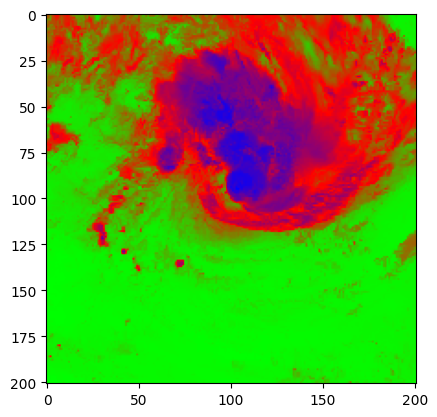

In [12]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.brg)

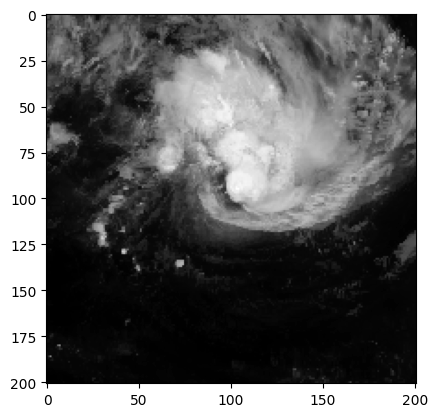

In [13]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.binary)

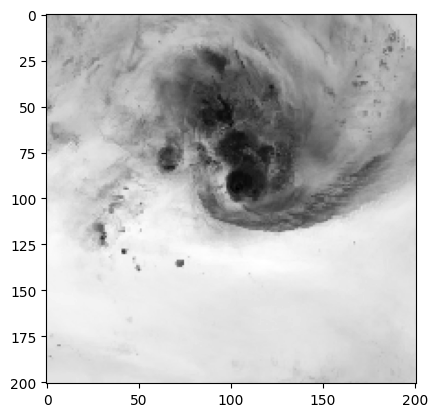

In [14]:
img = data_matrix[4000,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [15]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [16]:
data_info

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017-04-16 06:00:00,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017-04-16 09:00:00,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017-04-16 12:00:00,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017-04-16 15:00:00,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017-04-16 18:00:00,55.0,255.0,986.0
...,...,...,...,...,...,...,...,...
4575,WPAC,201733W,105.0,8.4,2017-12-26 00:00:00,20.0,0.0,1007.0
4576,WPAC,201733W,104.7,8.4,2017-12-26 03:00:00,20.0,0.0,1007.0
4577,WPAC,201733W,104.4,8.4,2017-12-26 06:00:00,20.0,0.0,1007.0
4578,WPAC,201733W,104.0,8.4,2017-12-26 09:00:00,18.0,0.0,1009.0


In [17]:
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [18]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

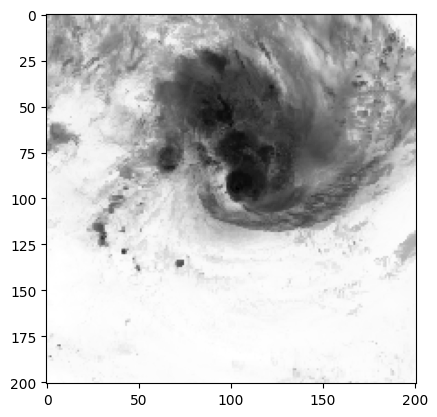

In [19]:
# X_std = tf.image.per_image_standardization(X_irpmw)
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [20]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

## Deep CNN

In [21]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )

    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model


In [22]:
model_history=[]
val_scores=[]
n_epochs=10
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Epoch 1/10


c:\Users\vrhem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


58/58 [==============================] - 6s 36ms/step - loss: 1195.5918 - mean_squared_error: 1195.5844
Epoch 2/10
58/58 [==============================] - 2s 35ms/step - loss: 835.9372 - mean_squared_error: 835.9312
Epoch 3/10
58/58 [==============================] - 2s 40ms/step - loss: 795.1613 - mean_squared_error: 795.1552
Epoch 4/10
58/58 [==============================] - 2s 42ms/step - loss: 736.0541 - mean_squared_error: 736.0475
Epoch 5/10
58/58 [==============================] - 2s 42ms/step - loss: 532.4005 - mean_squared_error: 532.3938
Epoch 6/10
58/58 [==============================] - 2s 39ms/step - loss: 384.6374 - mean_squared_error: 384.6306
Epoch 7/10
58/58 [==============================] - 2s 40ms/step - loss: 363.4451 - mean_squared_error: 363.4380
Epoch 8/10
58/58 [==============================] - 2s 40ms/step - loss: 358.6082 - mean_squared_error: 358.6008
Epoch 9/10
58/58 [==============================] - 2s 41ms/step - loss: 360.3253 - mean_squared_error: 3

In [23]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)
print('Test accuracy:', score[1])

13/13 [==============================] - 0s 8ms/step
Testing...
26/26 [==============================] - 0s 7ms/step - loss: 303.2332 - mean_squared_error: 303.2254
Test accuracy: 303.22540283203125


In [24]:
intensity = []
for x in y_pred:
    intensity.append(int(x))

C:\Users\vrhem\AppData\Local\Temp\ipykernel_2296\1398696241.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intensity.append(int(x))


In [25]:
# Categorize the cyclone intensity levels
cate = []
for x in intensity:
    if x <= 33:
        cate.append('Low')
    elif x > 33 and x <= 63:
        cate.append('Moderate')
    elif x > 63 and x <= 129:
        cate.append('High')
    elif x > 129:
        cate.append('Very High')

In [26]:
cate_dataset = list(zip(intensity,cate))

In [27]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Risk type',])

In [28]:
df

,Intensity,Risk type
0,60,Moderate
1,24,Low
2,23,Low
3,51,Moderate
4,25,Low
...,...,...
408,34,Moderate
409,28,Low
410,28,Low
411,26,Low


RNN

In [29]:
x_train = np.random.rand(100, 10, 4)  # Time series data with shape (samples, timesteps, features)
y_train = np.random.rand(100, 1)      # Target values

# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=64, activation='relu', input_shape=(10, 4)),  # Adjust units and input shape as needed
    tf.keras.layers.Dense(units=1)  # Output layer with 1 unit for regression
])


In [30]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
4/4 [==============================] - 3s 7ms/step - loss: 0.6902 - mean_squared_error: 0.6902
Epoch 2/10
4/4 [==============================] - 0s 6ms/step - loss: 0.1748 - mean_squared_error: 0.1748
Epoch 3/10
4/4 [==============================] - 0s 6ms/step - loss: 0.1057 - mean_squared_error: 0.1057
Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 0.1247 - mean_squared_error: 0.1247
Epoch 5/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0950 - mean_squared_error: 0.0950
Epoch 6/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0893 - mean_squared_error: 0.0893
Epoch 7/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0946 - mean_squared_error: 0.0946
Epoch 8/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0934 - mean_squared_error: 0.0934
Epoch 9/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0869 - mean_squared_error: 0.0869
Epoch 10/10
4/4 [=============================

In [31]:
# Make predictions using the trained model
rnn_y_pred = model.predict(x_train)

4/4 [==============================] - 0s 4ms/step


In [32]:
import pandas as pd

# Convert predicted intensity values to integers
intensity = []
for x in y_pred:
    intensity.append(int(x))

# Categorize the cyclone intensity levels
cate = []
for x in intensity:
    if x <= 33:
        cate.append('Low')
    elif x > 33 and x <= 63:
        cate.append('Moderate')
    elif x > 63 and x <= 129:
        cate.append('High')
    elif x > 129:
        cate.append('Very High')

# Create a DataFrame
data = {'Intensity value': intensity, 'Risk type': cate}
df = pd.DataFrame(data)

df


C:\Users\vrhem\AppData\Local\Temp\ipykernel_2296\3096529302.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intensity.append(int(x))


,Intensity value,Risk type
0,60,Moderate
1,24,Low
2,23,Low
3,51,Moderate
4,25,Low
...,...,...
408,34,Moderate
409,28,Low
410,28,Low
411,26,Low


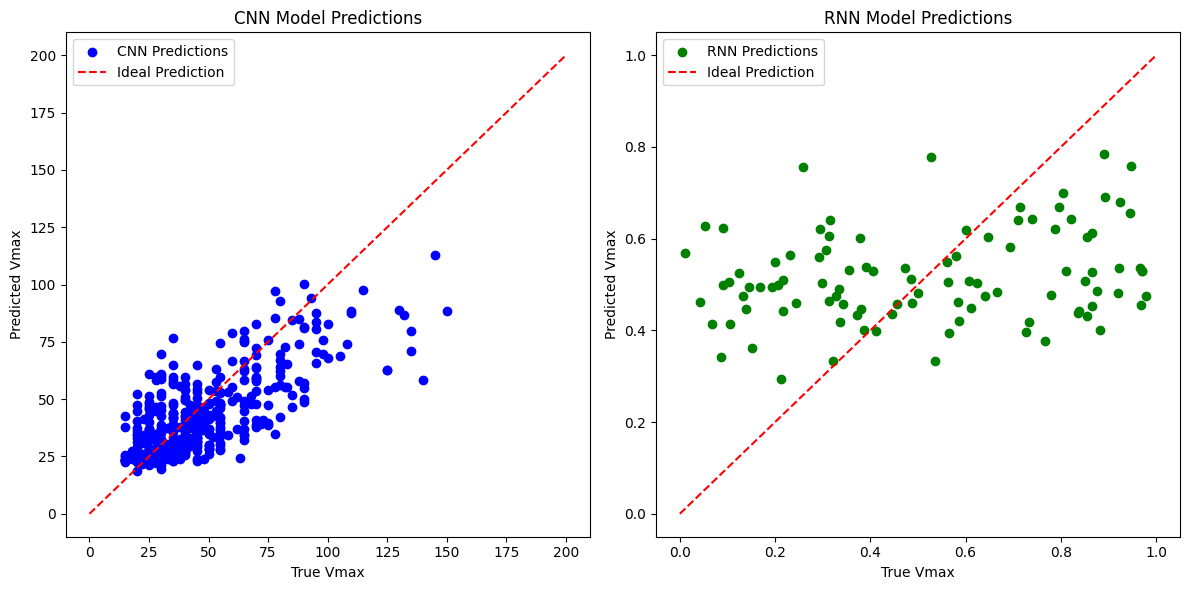

In [33]:
import matplotlib.pyplot as plt

# Create a scatter plot for CNN predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(test_y, y_pred, color='blue', label='CNN Predictions')
plt.plot([0, 200], [0, 200], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Vmax')
plt.ylabel('Predicted Vmax')
plt.title('CNN Model Predictions')
plt.legend()

# Create a scatter plot for RNN predictions
plt.subplot(1, 2, 2)
plt.scatter(y_train, rnn_y_pred, color='green', label='RNN Predictions')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Vmax')
plt.ylabel('Predicted Vmax')
plt.title('RNN Model Predictions')
plt.legend()

plt.tight_layout()
plt.show()
